# Dev notebook

In [39]:
import inspect
import os
import utils
import numpy as np
import xarray as xr
from scipy.ndimage import median_filter, gaussian_filter, binary_erosion, binary_dilation
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
url = '?date=2024-06-06&station_id=0-20008-0-UGR-A'
vars = ['attenuated_backscatter_0']

print(f'https://vprofiles.met.no/{url}')
yyyy, mm, dd, station_id = utils.get_parameters_from_url(url)
path = f'../data/{yyyy}/{mm}/{dd}/AP_{station_id}-{yyyy}-{mm}-{dd}.nc'

# read file
ds = xr.open_dataset(path)[vars].load()

https://vprofiles.met.no/?date=2024-06-06&station_id=0-20008-0-UGR-A


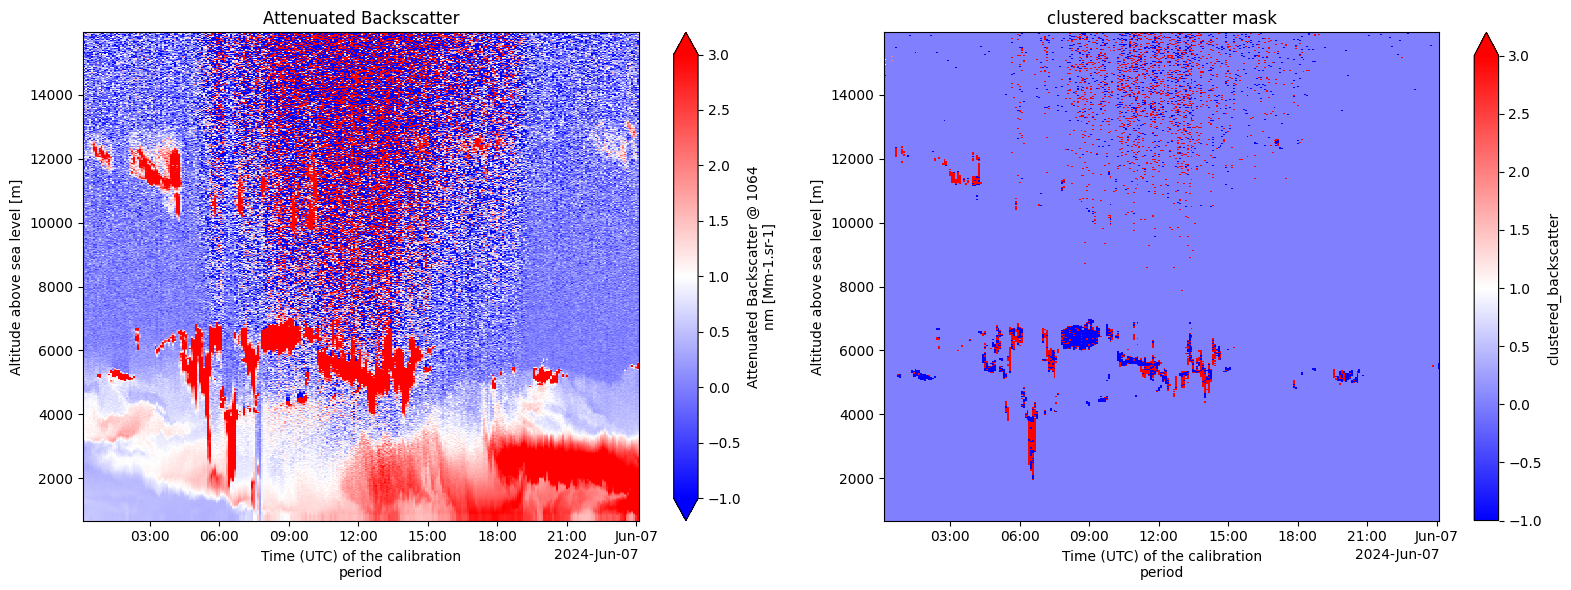

In [55]:
# set parameters
#thr_cloud = 0
#thr_snr = 0
eps = 0.1
min_samples = 2

# Apply SNR computation
ds = utils.snr(ds, 'attenuated_backscatter_0', step=2, log=False)

backscatter = ds['attenuated_backscatter_0'].data

# Remove NaN values (only keep valid points)
valid_mask = ~np.isnan(backscatter)
backscatter_valid = backscatter[valid_mask]

# Flatten the time-altitude grid into a 2D array of points (only for valid points)
altitudes = np.arange(backscatter.shape[1])
times = np.arange(backscatter.shape[0])
X, Y = np.meshgrid(times, altitudes)

# Filter out points where backscatter is NaN
X_valid = X.ravel()[valid_mask.ravel()]
Y_valid = Y.ravel()[valid_mask.ravel()]

# Create a dataset where points have (time, altitude, backscatter intensity)
points = np.column_stack([X_valid, Y_valid, backscatter_valid.ravel()])
points_normalized = StandardScaler().fit_transform(points)

# Apply DBSCAN clustering
db = DBSCAN(eps=eps, min_samples=min_samples).fit(points_normalized)
labels = db.labels_

# Reshape labels to match the original data dimensions (using NaN mask)
clustered_backscatter = np.full(backscatter.shape, -1)  # Initialize with -1 for noise
clustered_backscatter[valid_mask] = labels  # Assign labels to valid positions

# Save the clustered result to the dataset
ds['clustered_backscatter'] = xr.DataArray(clustered_backscatter, dims=ds.dims, coords=ds.coords)


# plot that
left = {'variable': 'attenuated_backscatter_0', 'title': 'Attenuated Backscatter', 'vmin': -1, 'vmax': 3, 'cmap': 'bwr'}
right = {'variable': 'clustered_backscatter','title': 'clustered backscatter mask','vmin': -1,'vmax': 3,'cmap': 'bwr'}
utils.plot_panel(ds, left, right, save=False, method='DBSCAN')
